# Performing classification analysis on Wisconsin breast cancer data set using neural networks

In this notebook we will train a neural network on the Wisconsin breast cancer data set and TODO

First, we are looking to uncover which modes and regularization parameters to use in our neural network:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from feedforward_nn import NeuralNetwork
from gradient_descent import GradientDescent
from regression_tools import accuracy

from sklearn.datasets import load_breast_cancer as wbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [4]:
"""
# Load data
data = wbc()
X = data.data
y = data.target

# Split data into training and test sets
X_TR, X_test, z_TR, z_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, z_train, z_val = train_test_split(X_TR, z_TR, test_size=0.2)
n = X_train.shape[1]

np.save("data/wbc/X_TR.npy", X_TR)
np.save("data/wbc/X_train.npy", X_train)
np.save("data/wbc/X_val.npy", X_val)
np.save("data/wbc/X_test.npy", X_test)
np.save("data/wbc/z_TR.npy", z_TR)
np.save("data/wbc/z_train.npy", z_train)
np.save("data/wbc/z_val.npy", z_val)
np.save("data/wbc/z_test.npy", z_test)
"""

X_TR = np.load("data/wbc/X_TR.npy")
X_train = np.load("data/wbc/X_train.npy")
X_val = np.load("data/wbc/X_val.npy")
X_test = np.load("data/wbc/X_test.npy")
z_TR = np.load("data/wbc/z_TR.npy")
z_train = np.load("data/wbc/z_train.npy")
z_val = np.load("data/wbc/z_val.npy")
z_test = np.load("data/wbc/z_test.npy")
n = X_train.shape[1]




In [5]:
# Use minimax to scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_TR = scaler.transform(X_TR)



In [5]:
def optimal_reg_neural_network(X_train, 
                               z_train, 
                               X_val, 
                               z_val, 
                               layers, 
                               regularizationrange, 
                               momentum=0.9,
                               avg_num = 10,
                               optmode="normal", 
                               max_iter=200, 
                               eta=0.01,
                               activation="sigmoid",
                               output_activation="sigmoid",
                               ):
    """Returns the optimal regularization parameter for a neural network with the given parameters, taking the average over avg_num runs."""
    accuracy_val = []
    cost_val = []
    for reg in regularizationrange:
        # Average over avg_num runs
        acc = 0
        cost = 0
        for _ in range(avg_num):
            nn = NeuralNetwork(layers, activation=activation, output_activation=output_activation, regularization=reg, cost_function="cross_entropy")
            w0 = nn.wb()
            batch_size = 16
            store_extra = True

            gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
            w = gd.train(X_train, w0, z_train, nn, eta, max_iter)
            cost += gd.costs[-1]
            z_pred = nn.predict_class(X_val, w)
            acc += accuracy(z_val, z_pred)
        cost /= avg_num
        acc /= avg_num
        accuracy_val.append(acc)
        cost_val.append(cost)
    # Return best regularization parameter, corresponding accuracy and accuracy_val
    return regularizationrange[np.argmax(accuracy_val)], np.max(accuracy_val), accuracy_val, cost_val
    

Analysis of convergence of neural network:

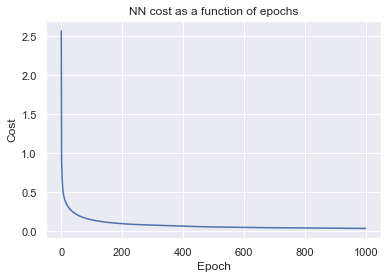

In [11]:
nn = NeuralNetwork([n, 20, 10, 1], activation="leaky_relu", output_activation="sigmoid", regularization=0.0, cost_function="cross_entropy")
w0 = nn.wb()
batch_size = 16
store_extra = True

gd = GradientDescent(batch_size=batch_size, momentum_param=0.0, store_extra=store_extra, mode="normal")
w = gd.train(X_train, w0, z_train, nn, 0.005, 1000)

costs = gd.costs
epochs = np.linspace(0, len(costs), len(costs))
sns.set_theme()
plt.plot(costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("NN cost as a function of epochs")
plt.savefig("plots/nn_cost_epochs.png")
plt.show()


We first want to explore which activation function gives us the best accuracy score, for a range of different regularization parameters.

In [9]:
# Perform grid search on regularization for each activation function
activations = ["linear", "sigmoid", "relu", "leaky_relu"]
best_lam = []
best_acc = []
accuracy_val = []
cost_val = []
avg_num = 10
max_iter = 500
eta = 0.005
layers = [n, 4, 4, 4, 4, 4, 1]
for activation in activations:
    print(f"Activation: {activation}")
    lambdas = np.logspace(-10, 2, 10)
    best_lam_act, best_acc_act, accuracy_val_act, cost_val_act = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layers, lambdas, optmode="normal", avg_num=avg_num, max_iter=max_iter, eta=eta, activation=activation)
    best_lam.append(best_lam_act)
    best_acc.append(best_acc_act)
    accuracy_val.append(accuracy_val_act)
    cost_val.append(cost_val_act)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNcancer_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Activation: {activation}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={eta}, layers={layers}\n")
        f.write(f"Best lambda: {best_lam_act}\n")
        f.write(f"Best accuracy: {best_acc_act}\n")
        f.write(f"Accuracy val: {accuracy_val_act}\n")
        f.write(f"Cost val: {cost_val_act}\n")
        f.write(f"--------------------------------------------------------\n")
        


Activation: linear
Activation: sigmoid
Activation: relu
Activation: leaky_relu


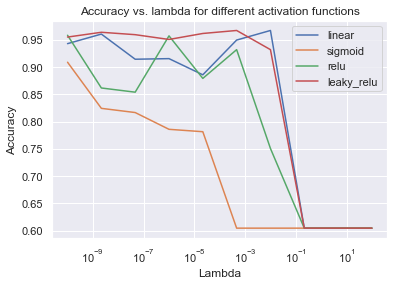

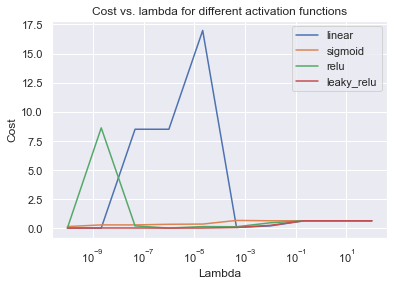

In [12]:
# Plot accuracy vs. regularization parameter for each activation function
for i in range(len(activations)):
    plt.semilogx(lambdas, accuracy_val[i], label=activations[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. lambda for different activation functions")
    plt.legend()
# Save figure as plots/accuracy_lambda_activation.png
plt.savefig("plots/accuracy_lambda_activation.png")
plt.show()

# Plot cost vs. regularization parameter for each activation function
for i in range(len(activations)):
    plt.semilogx(lambdas, cost_val[i], label=activations[i])
    plt.xlabel("Lambda")
    plt.ylabel("Cost")
    plt.title("Cost vs. lambda for different activation functions")
    plt.legend()
plt.show()



We choose the leaky_relu activation function henceforth as it outperforms the others.

In [13]:

# Grid search on regularization parameter for each mode - low resolution, as we only want to find the best mode
modes = ["normal", "adagrad", "rmsprop", "adam"]
best_lam = []
best_acc = []
accuracy_val = []
cost_val = []
avg_num = 10
max_iter = 500
eta = 0.005
layers = [n, 4, 4, 4, 4, 4, 1]
actfunc = "leaky_relu"
for mode in modes:
    print(f"Mode: {mode}")
    lambdas = np.logspace(-10, 2, 10)
    best_lam_mode, best_acc_mode, accuracy_val_mode, cost_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layers, lambdas, optmode=mode, avg_num=avg_num, max_iter=max_iter, eta=eta, activation=actfunc)
    best_lam.append(best_lam_mode)
    best_acc.append(best_acc_mode)
    accuracy_val.append(accuracy_val_mode)
    cost_val.append(cost_val_mode)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNcancer_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Iterating over modes\n")
        f.write(f"Mode: {mode}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={eta}, layers={layers}, activation={actfunc}\n")
        f.write(f"Best lambda: {best_lam_act}\n")
        f.write(f"Best accuracy: {best_acc_act}\n")
        f.write(f"Accuracy val: {accuracy_val_act}\n")
        f.write(f"Cost val: {cost_val_act}\n")
        f.write(f"--------------------------------------------------------\n")


Mode: normal
Mode: adagrad
Mode: rmsprop


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Mode: adam


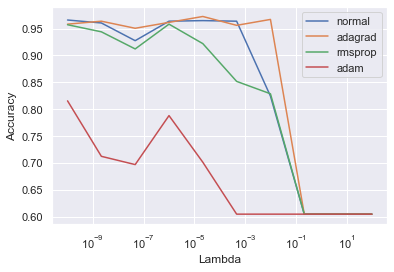

Mode	Best lambda	Accuracy
normal	1.00e-10	0.97
adagrad	2.15e-05	0.97
rmsprop	1.00e-06	0.96
adam	1.00e-10	0.82


In [15]:
# Plot accuracy vs. regularization parameter for each mode
for i in range(len(modes)):
    plt.semilogx(lambdas, accuracy_val[i], label=modes[i])
    plt.xlabel("Lambda")
    plt.ylabel("Accuracy")
    plt.legend()
# Save figure as plots/accuracy_lambda_mode.png
plt.savefig("plots/accuracy_lambda_mode.png")
plt.show()

# Print best regularization parameter for each mode as a table
print("Mode\tBest lambda\tAccuracy")
for i in range(len(modes)):
    print(f"{modes[i]}\t{best_lam[i]:.2e}\t{best_acc[i]:.2f}")

We see that adagrad consistently outperforms the other modes, and choose this mode in our further analysis.

In [29]:
# Perform grid search on learning rate and regularization parameter
lrrange = np.logspace(-4, -1, 8)
accuracy_mat = []
best_lam = []
best_acc = []
best_lr = []

avg_num = 8
max_iter = 400
layers = [n, 4, 4, 4, 4, 4, 1]
actfunc = "leaky_relu"
mode = "adagrad"
progress = 0
print(f"Progress: {100 * progress / len(lrrange):.2f}%", end="\r")
for lr in lrrange:
    lambdas = np.logspace(-12, -2, 10)
    best_lam_lr, best_acc_lr, accuracy_val_lr, cost_val_lr = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layers, lambdas, optmode=mode, avg_num=avg_num, max_iter=max_iter, eta=lr, activation=actfunc)
    accuracy_mat.append(accuracy_val_lr)
    best_lam.append(best_lam_lr)
    best_acc.append(best_acc_lr)
    best_lr.append(lr)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNcancer_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Iterating over learning rates\n")
        f.write(f"Learning rate: {lr}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={eta}, layers={layers}, activation={actfunc}\n")
        f.write(f"Best lambda: {best_lam_act}\n")
        f.write(f"Best accuracy: {best_acc_act}\n")
        f.write(f"Accuracy val: {accuracy_val_act}\n")
        f.write(f"Cost val: {cost_val_act}\n")
        f.write(f"--------------------------------------------------------\n")
    progress += 1/len(lrrange)
    print(f"Progress: {progress:.2%}", end="\r")



c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Best accuracy: 0.97
Best learning rate: 5.18e-03
Best lambda: 7.74e-04


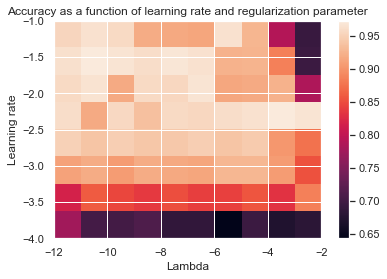

In [30]:
# Make heatmap plot of accuracy vs. learning rate and regularization parameter
accuracy_mat = np.array(accuracy_mat)
X, Y = np.meshgrid(lambdas, lrrange)
fig = plt.figure()
plt.imshow(accuracy_mat, extent=[np.log10(lambdas[0]), np.log10(lambdas[-1]), np.log10(lrrange[0]), np.log10(lrrange[-1])], origin="lower", aspect="auto")
plt.colorbar()
plt.xlabel("Lambda")
plt.ylabel("Learning rate")
plt.title("Accuracy as a function of learning rate and regularization parameter")
# Save figure as plots/accuracy_lambda_lr.png
plt.savefig("plots/accuracy_lambda_lr.png")

# Print best accuracy and corresponding learning rate and regularization parameter
best_acc = 0
best_lr = 0
best_lam = 0
for i in range(len(lrrange)):
    for j in range(len(lambdas)):
        if accuracy_mat[i, j] > best_acc:
            best_acc = accuracy_mat[i, j]
            best_lr = lrrange[i]
            best_lam = lambdas[j]
print(f"Best accuracy: {best_acc:.2f}")
print(f"Best learning rate: {best_lr:.2e}")
print(f"Best lambda: {best_lam:.2e}")


We see that the optimal accuracy is reached with a learning rate of around 0.005, and that the optimal regularization parameter is about 0.0008, and we will use this going forward.

We will now find the optimal regularization parameter, with these previous parameters, for different neural network structures - that is, different amounts of layers, and different amounts of nodes in these layers.

In [6]:
nn_structures = [
    [n, 10, 10, 10, 10, 10, 1],
    [n, 10, 10, 1],
    [n, 4, 4, 4, 4, 4, 1],
    [n, 4, 4, 1]
]

avg_num = 10
max_iter = 500
actfunc = "leaky_relu"
mode = "adagrad"
eta = 0.005

nn_best_lambda = []
nn_best_acc = []
nn_accuracy_vals = []

# Perform grid search on regularization for adagrad with leaky relu, learning rate 0.005 and regularization between 0.01 and 1000
lambdas = np.logspace(-12, 2, 15)
for nn in nn_structures:
    print(f"Neural network structure: {nn}")
    best_lam_nn, best_acc_nn, accuracy_val_nn, cost_val_nn = optimal_reg_neural_network(X_train, z_train, X_val, z_val, nn, lambdas, optmode=mode, avg_num=avg_num, max_iter=max_iter, eta=0.005, activation=actfunc)
    nn_best_lambda.append(best_lam_nn)
    nn_best_acc.append(best_acc_nn)
    nn_accuracy_vals.append(accuracy_val_nn)
    # Save to file notebooks/NNcancer_gridsearch.txt
    with open("Results/NNcancer_gridsearch.txt", "a") as f:
        # Add space
        f.write(f"\n\n")
        f.write(f"Iterating over neural network structures\n")
        f.write(f"Layers: {nn}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={eta}, learning rate={eta}, activation={actfunc}\n")
        f.write(f"Best lambda: {best_lam_nn}\n")
        f.write(f"Best accuracy: {best_acc_nn}\n")
        f.write(f"Accuracy val: {accuracy_val_nn}\n")
        f.write(f"Cost val: {cost_val_nn}\n")
        f.write(f"--------------------------------------------------------\n")


Neural network structure: [30, 10, 10, 10, 10, 10, 1]


c:\Users\leand\FYS-STK\FYS-STK3155-project-2\feedforward_nn.py:90: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Neural network structure: [30, 10, 10, 1]
Neural network structure: [30, 4, 4, 4, 4, 4, 1]
Neural network structure: [30, 4, 4, 1]


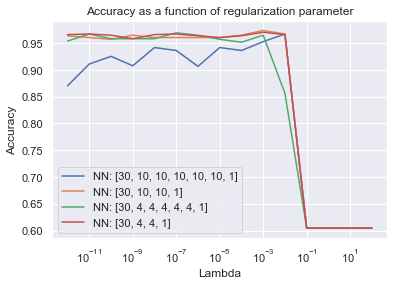

Best accuracy for NN: [30, 10, 10, 10, 10, 10, 1]: 0.9670
Best lambda for NN: [30, 10, 10, 10, 10, 10, 1]: 1.0000e-02
Best accuracy for NN: [30, 10, 10, 1]: 0.9736
Best lambda for NN: [30, 10, 10, 1]: 1.0000e-03
Best accuracy for NN: [30, 4, 4, 4, 4, 4, 1]: 0.9692
Best lambda for NN: [30, 4, 4, 4, 4, 4, 1]: 1.0000e-07
Best accuracy for NN: [30, 4, 4, 1]: 0.9703
Best lambda for NN: [30, 4, 4, 1]: 1.0000e-03
[1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03
 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


In [9]:
# Plot accuracy as a function of regularization parameter for each neural network structure
sns.set_theme()
for i in range(len(nn_structures)):
    plt.plot(lambdas, nn_accuracy_vals[i], label=f"NN: {nn_structures[i]}")
plt.semilogx()
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of regularization parameter")
plt.legend()
# Save figure as plots/accuracy_lambda_nn.png
plt.savefig("plots/accuracy_lambda_nn.png")
plt.show()

# Print best accuracy and corresponding regularization parameter for each neural network structure
for i in range(len(nn_structures)):
    print(f"Best accuracy for NN: {nn_structures[i]}: {nn_best_acc[i]:.4f}")
    print(f"Best lambda for NN: {nn_structures[i]}: {lambdas[np.argmax(nn_accuracy_vals[i])]:.4e}")

print(lambdas)

    

In [33]:
# Find the average accuracy for the best model on the test set
best_nn = nn_structures[np.argmax(nn_best_acc)]
lam = nn_best_lambda[np.argmax(nn_best_acc)]
max_iter = 500
actfunc = "leaky_relu"
mode = "adagrad"
eta = 0.005
avg_num = 50
acc = 0
for i in range(avg_num):
    nn = NeuralNetwork(best_nn, activation=actfunc, output_activation="sigmoid", regularization=lam, cost_function="cross_entropy")
    w0 = nn.wb()
    batch_size = 16
    store_extra = True

    gd = GradientDescent(batch_size=batch_size, momentum_param=0.9, store_extra=store_extra, mode=mode)
    w = gd.train(X_TR, w0, z_TR, nn, eta, max_iter)
    z_pred = nn.predict_class(X_test, w)
    acc += accuracy(z_test, z_pred)
acc /= avg_num
print(f"Average accuracy on test set: {acc:.4f}")

Average accuracy on test set: 0.9789


In [17]:
# Create confusion matrix for the best model
def confusion_matrix(z_true, z_pred):
    """Create confusion matrix for the predictions of a model."""
    conf_mat = np.zeros((2, 2))

    for i in range(len(z_true)):
        if z_true[i] == 0 and z_pred[i] == 0:
            conf_mat[0, 0] += 1
        elif z_true[i] == 0 and z_pred[i] == 1:
            conf_mat[0, 1] += 1
        elif z_true[i] == 1 and z_pred[i] == 0:
            conf_mat[1, 0] += 1
        elif z_true[i] == 1 and z_pred[i] == 1:
            conf_mat[1, 1] += 1 
        else:
            raise ValueError("z_true and z_pred must be binary")

    return conf_mat

# Create confusion matrix for the best model
# Average over 50 runs
avg_num = 50
cm = np.zeros((2, 2))
progress = 0
print(f"Progress: {progress:.2f}%", end="\r")
for i in range(avg_num):
    nn = NeuralNetwork([30, 10, 10, 1], activation="leaky_relu", output_activation="sigmoid", regularization=0.001, cost_function="cross_entropy")
    w0 = nn.wb()
    batch_size = 16
    store_extra = True

    gd = GradientDescent(batch_size=batch_size, momentum_param=0.9, store_extra=store_extra, mode="adagrad")
    w = gd.train(X_TR, w0, z_TR, nn, 0.005, 500)
    z_pred = nn.predict_class(X_test, w)
    cm += confusion_matrix(z_test, z_pred)
    progress = (i+1)/avg_num*100
    print(f"Progress: {progress:.2f}%", end="\r")
cm /= avg_num
print("            ")
print("            ")
print(cm)

            0.00%
            
[[40.56  1.44]
 [ 1.06 70.94]]


In [18]:
# Scale the confusion matrix
cm = cm/cm.sum(axis=1, keepdims=True)
print(cm)

[[0.96571429 0.03428571]
 [0.01472222 0.98527778]]


### Comparison with Scikit-learn

We will now compare our results with those we get with sklearn.

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

avg_num = 100
acc = 0
for i in range(avg_num):
    model_sklearn = MLPClassifier(hidden_layer_sizes=(10, 10), activation="relu", solver="adam", alpha=0.001, max_iter=500, learning_rate_init=0.005)

    model_sklearn.fit(X_TR, z_TR)
    z_pred = model_sklearn.predict(X_test)
    acc_temp = accuracy_score(z_test, z_pred)
    acc += acc_temp
acc /= avg_num
print(f"Average accuracy on test set: {acc:.4f}")



Average accuracy on test set: 0.9761
